# Heart Rate Recovery Study

This notebook:
- Loads 30 `name_dayX.csv` files from a ZIP.
- Converts RR intervals to heart rate (bpm) and removes outliers (HR < 30 or HR > 200).
- Produces report-ready **violin** and **box-and-whisker** plots (numbered).
- Produces numbered tables and exports plots/tables to files.

All outputs are saved to: `report_outputs/`  
- Figures: PNG + PDF  
- Tables: CSV + LaTeX

In [216]:
# ---- Setup ----
import os, re, zipfile, glob, math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM

from IPython.display import display

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 140)

In [217]:
# ---- Configure paths ----
ZIP_PATH = "RRData.zip"           # update if needed
EXTRACT_DIR = "RRData_extracted"  # extracted CSVs will go here

DAY_TO_RECOVERY = {1: "silence", 2: "music", 3: "nature"}
PHASE_ORDER = ["baseline", "noise", "recovery"]
RECOVERY_ORDER = ["silence", "music", "nature"]

In [218]:
# ---- Extract ZIP ----
os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    for name in z.namelist():
        if name.startswith("__MACOSX/") or name.endswith("/") or os.path.basename(name).startswith("._"):
            continue
        z.extract(name, EXTRACT_DIR)

csv_files = sorted(glob.glob(os.path.join(EXTRACT_DIR, "*.csv")))
print(f"Found {len(csv_files)} CSV files.")
assert len(csv_files) == 30, "Expected exactly 30 CSV files after extraction."
print("Example files:", [os.path.basename(p) for p in csv_files[:5]])

Found 30 CSV files.
Example files: ['jacob_day1.csv', 'jacob_day2.csv', 'jacob_day3.csv', 'lucas_day1.csv', 'lucas_day2.csv']


In [219]:
# ---- Helpers ----
def parse_filename(path: str):
    base = os.path.basename(path)
    m = re.match(r"(.+)_day(\d+)\.csv$", base, flags=re.IGNORECASE)
    if not m:
        raise ValueError(f"Unexpected filename: {base} (expected name_dayX.csv)")
    subject = m.group(1)
    day = int(m.group(2))
    recovery_type = DAY_TO_RECOVERY.get(day, f"day{day}")
    return subject, day, recovery_type

def rr_to_bpm(rr_series: pd.Series) -> pd.Series:
    """Convert RR intervals to bpm. Detects ms vs seconds via median heuristic.
    Filters outliers by HR < 30 or HR > 200 (returns NaN for filtered beats).
    """
    rr = pd.to_numeric(rr_series, errors="coerce")
    rr = rr.where(rr > 0)

    if rr.dropna().empty:
        return rr * np.nan

    med = float(rr.median())
    rr_sec = rr / 1000.0 if med > 10 else rr.astype(float)  # ms → sec heuristic
    bpm = 60.0 / rr_sec
    bpm = bpm.where((bpm >= 30) & (bpm <= 130))
    return bpm

def identify_columns(df: pd.DataFrame):
    cols_lower = [c.strip().lower() for c in df.columns]
    colmap = {c.strip().lower(): c for c in df.columns}

    if "baseline" not in cols_lower or "noise" not in cols_lower:
        raise ValueError(f"Missing required columns. Found: {df.columns.tolist()}")

    baseline_col = colmap["baseline"]
    noise_col = colmap["noise"]

    rec_col = None
    for cand in ["silence", "music", "nature"]:
        if cand in cols_lower:
            rec_col = colmap[cand]
            break

    if rec_col is None:
        remaining = [c for c in df.columns if c.strip().lower() not in ("baseline", "noise")]
        if not remaining:
            raise ValueError(f"Could not find recovery column in: {df.columns.tolist()}")
        rec_col = remaining[0]

    return baseline_col, noise_col, rec_col

def mean_ci(x: np.ndarray, alpha=0.05):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    m = float(np.mean(x)) if n else np.nan
    s = float(np.std(x, ddof=1)) if n > 1 else np.nan
    se = s / math.sqrt(n) if n > 1 else np.nan
    lo, hi = st.t.interval(1 - alpha, df=n - 1, loc=m, scale=se) if n > 1 else (np.nan, np.nan)
    return n, m, lo, hi

In [220]:
# =========================
# Report outputs: numbering, formatting, saving
# =========================
OUTPUT_DIR = "report_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

FIG_NO = 0
TABLE_NO = 0

def next_figure(title: str) -> str:
    global FIG_NO
    FIG_NO += 1
    return f"Figure {FIG_NO}. {title}"

def next_table(title: str) -> str:
    global TABLE_NO
    TABLE_NO += 1
    return f"Table {TABLE_NO}. {title}"

def save_figure(fig, base_name: str):
    fig.savefig(os.path.join(OUTPUT_DIR, f"{base_name}.png"), bbox_inches="tight", dpi=300)
    fig.savefig(os.path.join(OUTPUT_DIR, f"{base_name}.pdf"), bbox_inches="tight")
    print(f"Saved: {base_name}.png/.pdf -> {OUTPUT_DIR}/")

def save_table(df: pd.DataFrame, base_name: str):
    df.to_csv(os.path.join(OUTPUT_DIR, f"{base_name}.csv"), index=False)
    df.to_latex(os.path.join(OUTPUT_DIR, f"{base_name}.tex"), index=False)
    print(f"Saved: {base_name}.csv/.tex -> {OUTPUT_DIR}/")

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

In [221]:
# ---- Load + clean into long format ----
rows = []
qc_rows = []

for path in csv_files:
    subject, day, recovery_type = parse_filename(path)
    raw = pd.read_csv(path)

    baseline_col, noise_col, rec_col = identify_columns(raw)
    phase_specs = [("baseline", baseline_col), ("noise", noise_col), ("recovery", rec_col)]

    for phase, col in phase_specs:
        bpm = rr_to_bpm(raw[col])

        n_total = int(pd.to_numeric(raw[col], errors="coerce").notna().sum())
        n_kept = int(bpm.notna().sum())
        qc_rows.append({
            "subject": subject,
            "day": day,
            "recovery_type": recovery_type,
            "phase": phase,
            "beats_total": n_total,
            "beats_kept": n_kept,
            "pct_kept": (n_kept / n_total * 100) if n_total else np.nan
        })

        for v in bpm.dropna().values:
            rows.append({
                "subject": subject,
                "day": day,
                "recovery_type": recovery_type,
                "phase": phase,
                "hr_bpm": float(v)
            })

df_long = pd.DataFrame(rows)
df_qc = pd.DataFrame(qc_rows)

df_long["phase"] = pd.Categorical(df_long["phase"], categories=PHASE_ORDER, ordered=True)
df_long["recovery_type"] = pd.Categorical(df_long["recovery_type"], categories=RECOVERY_ORDER, ordered=True)

print("Long dataframe shape:", df_long.shape)
display(df_long.head())

Long dataframe shape: (13843, 5)


,subject,day,recovery_type,phase,hr_bpm
0,jacob,1,silence,baseline,63.492063
1,jacob,1,silence,baseline,63.424947
2,jacob,1,silence,baseline,63.424947
3,jacob,1,silence,baseline,68.649886
4,jacob,1,silence,baseline,69.124424


In [222]:
#For Report, # of data points removed from cleaning
# =========================
# Table: Cleaning removals (raw RR points removed by HR outlier filter)
# Requires: df_qc (created during loading), save_table(), next_table()
# =========================

# File-level removals by phase
removals_file = df_qc.copy()
removals_file["beats_removed"] = removals_file["beats_total"] - removals_file["beats_kept"]
removals_file["pct_removed"] = 100 * removals_file["beats_removed"] / removals_file["beats_total"].replace({0: np.nan})

removals_file = removals_file.rename(columns={
    "recovery_type": "Recovery Type",
    "phase": "Phase",
    "beats_total": "Raw Points",
    "beats_kept": "Kept Points",
    "beats_removed": "Removed Points",
    "pct_removed": "Percent Removed"
})

# Summary by recovery type and phase (report-facing)
removals_summary = (
    removals_file.groupby(["Recovery Type", "Phase"], observed=True)[["Raw Points", "Kept Points", "Removed Points"]]
    .sum()
    .reset_index()
)
removals_summary["Percent Removed"] = (
    100 * removals_summary["Removed Points"] / removals_summary["Raw Points"].replace({0: np.nan})
)

# Grand totals row
tot = pd.DataFrame([{
    "Recovery Type": "All",
    "Phase": "All",
    "Raw Points": removals_summary["Raw Points"].sum(),
    "Kept Points": removals_summary["Kept Points"].sum(),
    "Removed Points": removals_summary["Removed Points"].sum(),
    "Percent Removed": 100 * removals_summary["Removed Points"].sum() / removals_summary["Raw Points"].sum()
}])

removals_summary = pd.concat([removals_summary, tot], ignore_index=True)

# Make labels report-friendly (only if you're using lowercase in df_qc)
phase_labels = {"baseline": "Baseline", "noise": "Noise", "recovery": "Recovery"}
recovery_labels = {"silence": "Silence", "music": "Music", "nature": "Nature"}

removals_summary["Phase"] = removals_summary["Phase"].map(lambda x: phase_labels.get(x, x))
removals_summary["Recovery Type"] = removals_summary["Recovery Type"].map(lambda x: recovery_labels.get(x, x))

# Order rows nicely
phase_order_disp = ["Baseline", "Noise", "Recovery", "All"]
recovery_order_disp = ["Silence", "Music", "Nature", "All"]
removals_summary["Phase"] = pd.Categorical(removals_summary["Phase"], categories=phase_order_disp, ordered=True)
removals_summary["Recovery Type"] = pd.Categorical(removals_summary["Recovery Type"], categories=recovery_order_disp, ordered=True)
removals_summary = removals_summary.sort_values(["Recovery Type", "Phase"]).reset_index(drop=True)

# Round percentage for display
removals_summary["Percent Removed"] = removals_summary["Percent Removed"].astype(float).round(1)

print(next_table("Raw RR points removed by cleaning (HR < 30 bpm or HR > 200 bpm)."))
display(removals_summary)

#save_table(removals_summary, "Table_1_Cleaning_Removals_Summary")



Table 1. Raw RR points removed by cleaning (HR < 30 bpm or HR > 200 bpm).


,Recovery Type,Phase,Raw Points,Kept Points,Removed Points,Percent Removed
0,Silence,Baseline,703,699,4,0.6
1,Silence,Noise,3531,3465,66,1.9
2,Silence,Recovery,720,714,6,0.8
3,Music,Baseline,619,618,1,0.2
4,Music,Noise,3211,3178,33,1.0
5,Music,Recovery,643,611,32,5.0
6,Nature,Baseline,634,634,0,0.0
7,Nature,Noise,3275,3273,2,0.1
8,Nature,Recovery,651,651,0,0.0
9,All,All,13987,13843,144,1.0


In [223]:
# ---- Display labels (do not mutate df_long; use a display copy) ----
phase_labels = {"baseline": "Baseline", "noise": "Noise", "recovery": "Recovery"}
recovery_labels = {"silence": "Silence", "music": "Music", "nature": "Nature"}

plot_df = df_long.copy()
plot_df["Phase"] = plot_df["phase"].map(phase_labels)
plot_df["Recovery Type"] = plot_df["recovery_type"].map(recovery_labels)

phase_order_disp = [phase_labels[p] for p in PHASE_ORDER]
recovery_order_disp = [recovery_labels[r] for r in RECOVERY_ORDER]

In [224]:
# =========================
# Table: Sample sizes by recovery type and phase
# =========================
tab_sizes = (
    plot_df.groupby(["Recovery Type", "Phase"])
    .agg(Participants=("subject", "nunique"), Beats=("hr_bpm", "count"))
    .reset_index()
)

print(next_table("Sample sizes by recovery type and phase."))
display(tab_sizes)

Table 2. Sample sizes by recovery type and phase.


/var/folders/n5/z3_hbxx5557gt7c6h2ldp3140000gn/T/ipykernel_45728/1765873494.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df.groupby(["Recovery Type", "Phase"])


,Recovery Type,Phase,Participants,Beats
0,Silence,Baseline,10,699
1,Silence,Noise,10,3465
2,Silence,Recovery,10,714
3,Music,Baseline,10,618
4,Music,Noise,10,3178
5,Music,Recovery,10,611
6,Nature,Baseline,10,634
7,Nature,Noise,10,3273
8,Nature,Recovery,10,651


Saved: Figure_1_Violin_Plots.png/.pdf -> report_outputs/


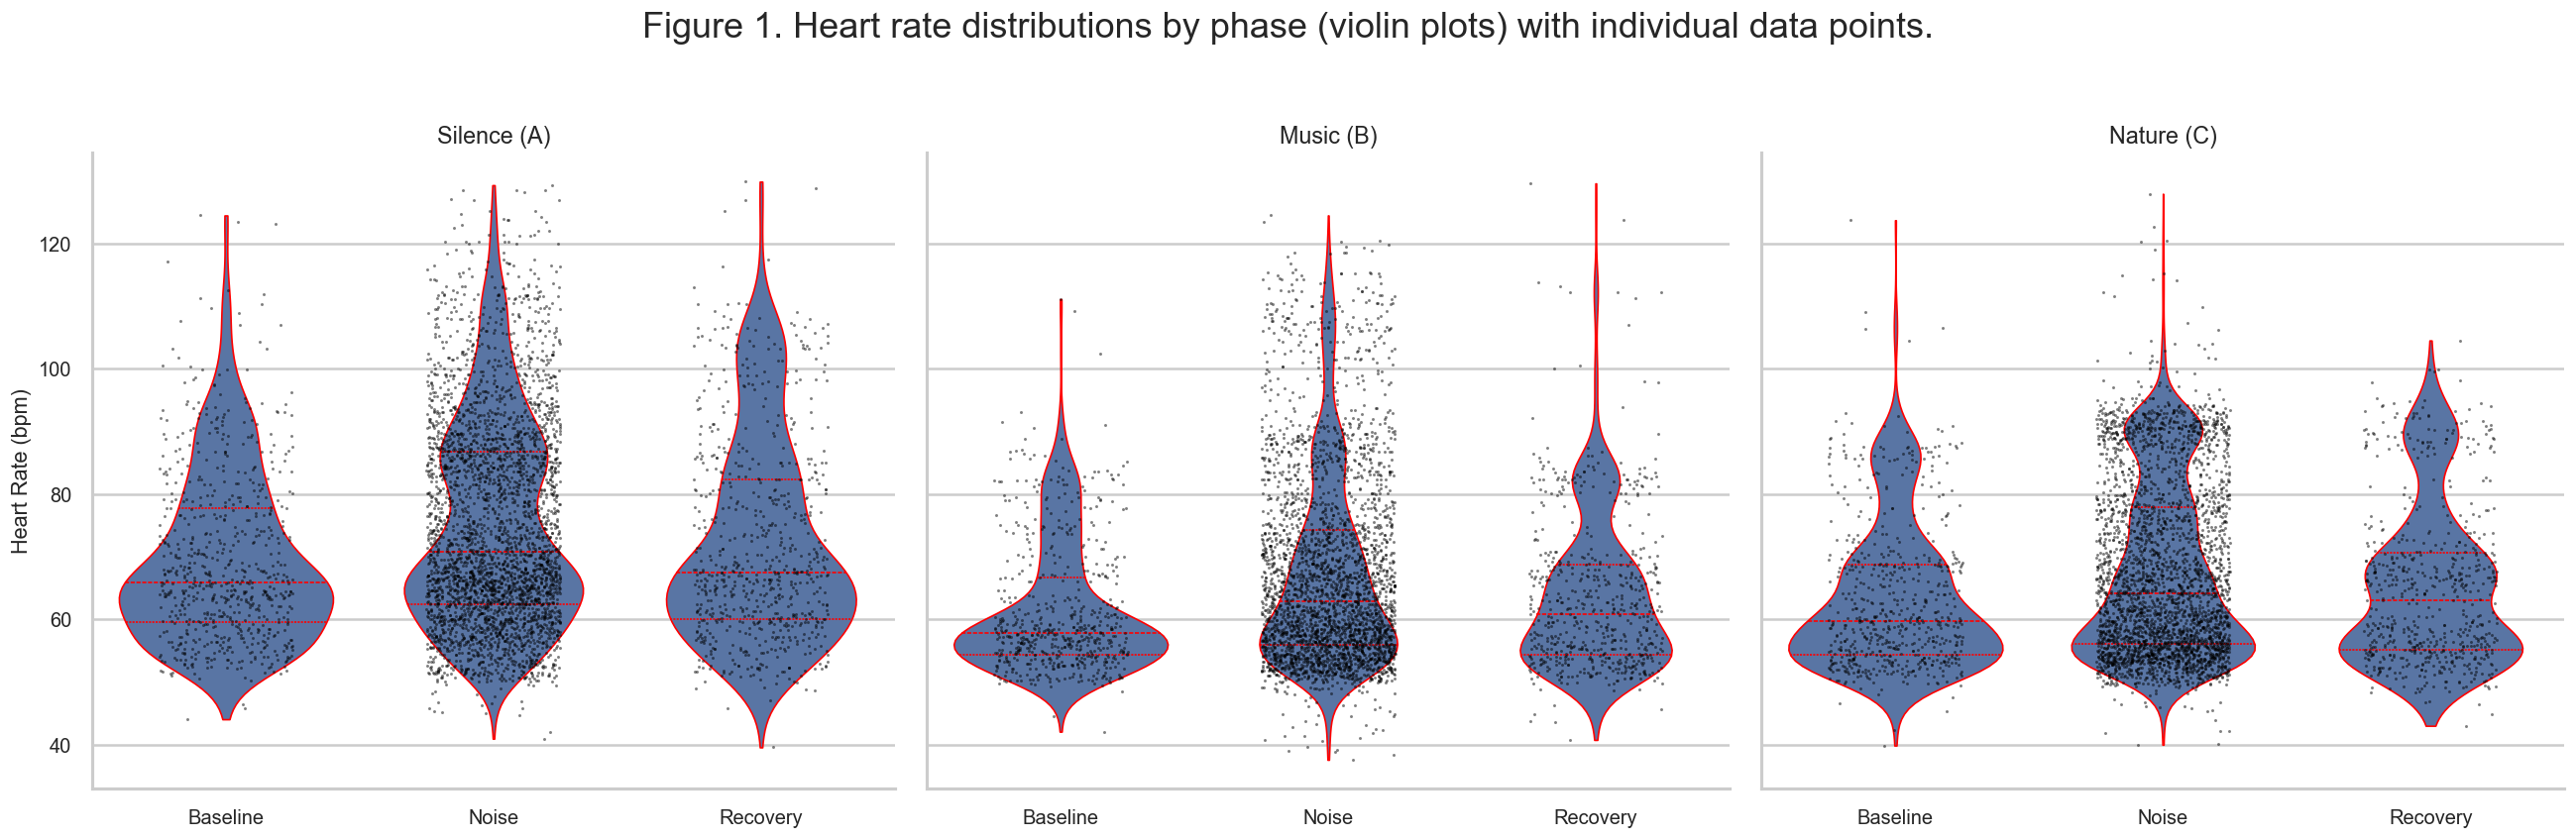

In [ ]:
# =========================
# Figure: Violin plots (beat-level HR) + individual data points
# =========================
fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharey=True)
panel_titles = {
    "Silence": "Silence (A)",
    "Music": "Music (B)",
    "Nature": "Nature (C)",
}


for ax, rec in zip(axes, recovery_order_disp):
    sub = plot_df[plot_df["Recovery Type"] == rec]

    sns.violinplot(
        data=sub, x="Phase", y="hr_bpm",
        order=phase_order_disp, ax=ax,
        inner="quartile", cut=0, linewidth=1, edgecolor="red"
    )


    # Overlay individual beat-level points (jittered)
    sns.stripplot(
    data=sub, x="Phase", y="hr_bpm",
    order=phase_order_disp, ax=ax,
    jitter=0.25, size=1.5, alpha=0.5,
    color="black",          # dot color
    edgecolor="black",      # helps visibility
    linewidth=0.2
)

    ax.set_title(panel_titles.get(rec, rec))
    ax.set_xlabel("")
    ax.set_ylabel("Heart Rate (bpm)" if rec == recovery_order_disp[0] else "")
    ax.grid(True, axis="y", alpha=1)
    sns.despine(ax=ax)

fig.suptitle(next_figure("Heart rate distributions by phase (violin plots) with individual data points."), y=1.02)
fig.tight_layout()

fig = plt.gcf()
#save_figure(fig, "Figure_1_Violin_Plots")
plt.show()


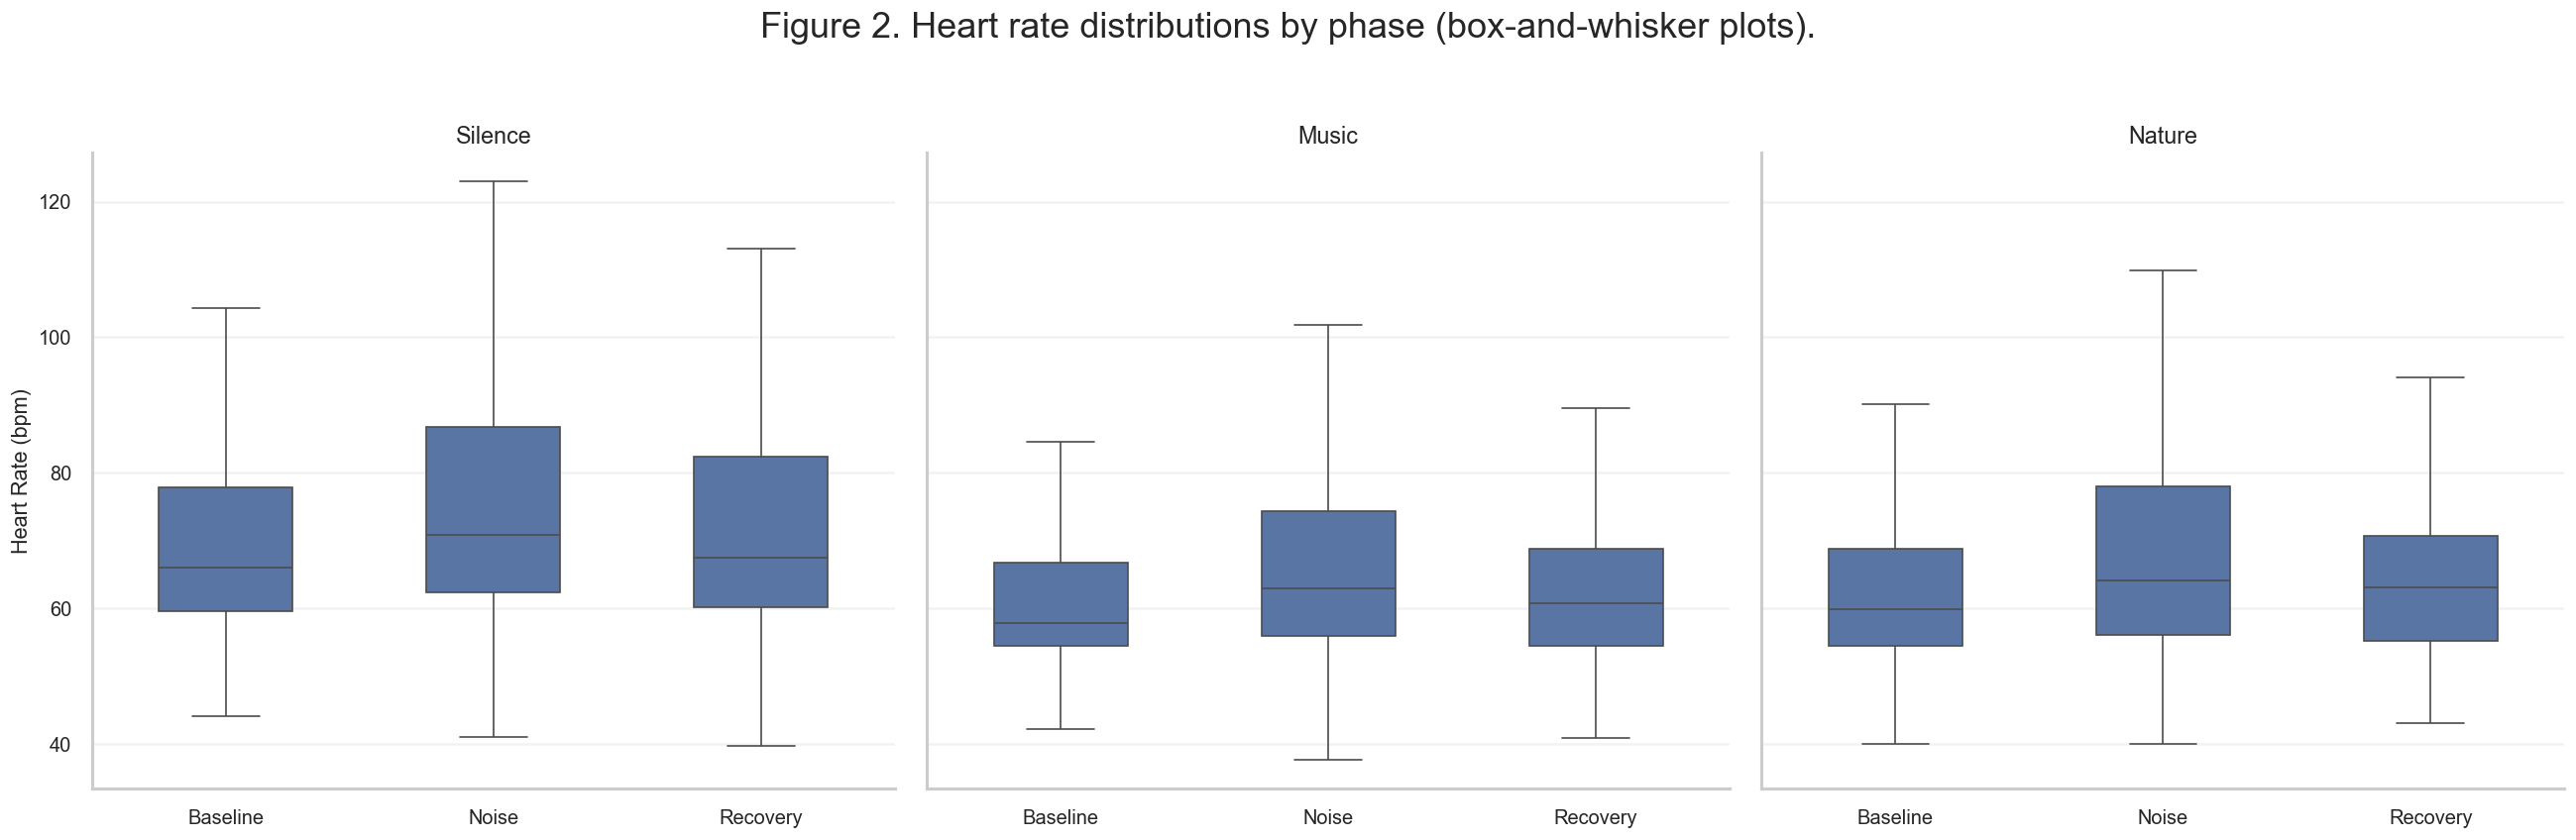

In [226]:
# =========================
# Figure: Box-and-whisker plots (beat-level HR)
# =========================
fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharey=True)

for ax, rec in zip(axes, recovery_order_disp):
    sub = plot_df[plot_df["Recovery Type"] == rec]
    sns.boxplot(
        data=sub, x="Phase", y="hr_bpm",
        order=phase_order_disp, ax=ax,
        showfliers=False,
        width=0.5
    )
    ax.set_title(rec)
    ax.set_xlabel("")
    ax.set_ylabel("Heart Rate (bpm)" if rec == recovery_order_disp[0] else "")
    ax.grid(True, axis="y", alpha=0.25)
    sns.despine(ax=ax)

fig.suptitle(next_figure("Heart rate distributions by phase (box-and-whisker plots)."), y=1.02)
fig.tight_layout()
#save_figure(fig, "Figure_2_Box_Plots")
plt.show()

In [227]:
# ---- Subject-level phase means (primary analysis uses within-subject deltas) ----
phase_means = (df_long.groupby(["subject","recovery_type","phase"])["hr_bpm"]
               .mean()
               .reset_index())

wide = (phase_means.pivot_table(index=["subject","recovery_type"], columns="phase", values="hr_bpm")
        .reset_index())

wide["delta_noise_to_recovery"] = wide["noise"] - wide["recovery"]
wide["delta_noise_to_baseline"] = wide["noise"] - wide["baseline"]

display(wide.head())

/var/folders/n5/z3_hbxx5557gt7c6h2ldp3140000gn/T/ipykernel_45728/4055247775.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  phase_means = (df_long.groupby(["subject","recovery_type","phase"])["hr_bpm"]
/var/folders/n5/z3_hbxx5557gt7c6h2ldp3140000gn/T/ipykernel_45728/4055247775.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = (phase_means.pivot_table(index=["subject","recovery_type"], columns="phase", values="hr_bpm")


phase,subject,recovery_type,baseline,noise,recovery,delta_noise_to_recovery,delta_noise_to_baseline
0,jacob,silence,65.793831,69.646711,63.107372,6.539340,3.852880
1,jacob,music,60.809026,67.489929,62.784544,4.705385,6.680903
2,jacob,nature,59.965801,67.553310,59.021651,8.531659,7.587509
3,lucas,silence,66.281650,74.769752,59.321299,15.448453,8.488102
4,lucas,music,57.105220,62.979842,73.662923,-10.683081,5.874622


In [228]:
# =========================
# Table: Overall noise effect (Noise − Baseline), pooled across all subject-days
# (Independent of recovery type)
# Requires: wide, mean_ci(), save_table(), next_table()
# =========================

x = wide["delta_noise_to_baseline"].astype(float).values  # Noise - Baseline for each subject-day
n, m, lo, hi = mean_ci(x)

overall_noise = pd.DataFrame([{
    "Observations (subject-days)": n,
    "Mean HR Increase (bpm)": m,
    "95% CI (Low)": lo,
    "95% CI (High)": hi
}])

# formatting for display (optional)
overall_noise_disp = overall_noise.copy()
for c in ["Mean HR Increase (bpm)", "95% CI (Low)", "95% CI (High)"]:
    overall_noise_disp[c] = overall_noise_disp[c].astype(float).round(2)

print(next_table("Overall effect of construction noise on baseline heart rate (Noise − Baseline), pooled across subject-days."))
display(overall_noise_disp)

#save_table(overall_noise, "Table_2_Noise_Effect_Overall_SubjectDays")



Table 3. Overall effect of construction noise on baseline heart rate (Noise − Baseline), pooled across subject-days.


,Observations (subject-days),Mean HR Increase (bpm),95% CI (Low),95% CI (High)
0,30,4.61,3.02,6.2


In [229]:
# =========================
# Table: Primary outcome (mean HR drop) with 95% CI (no p-values shown)
# =========================
rows = []
for rt in RECOVERY_ORDER:
    x = wide.loc[wide["recovery_type"] == rt, "delta_noise_to_recovery"].values
    n, m, lo, hi = mean_ci(x)
    rows.append({
        "Recovery Type": recovery_labels[rt],
        "Participants (n)": n,
        "Mean HR Drop (bpm)": m,
        "95% CI (Low)": lo,
        "95% CI (High)": hi
    })

hr_summary = pd.DataFrame(rows).sort_values("Mean HR Drop (bpm)", ascending=False).reset_index(drop=True)
hr_summary.insert(0, "Rank", np.arange(1, len(hr_summary) + 1))

print(next_table("Primary outcome: mean heart-rate drop from noise to recovery."))
display(hr_summary)
#save_table(hr_summary, "Table_3_Primary_MeanDrop")

Table 4. Primary outcome: mean heart-rate drop from noise to recovery.


,Rank,Recovery Type,Participants (n),Mean HR Drop (bpm),95% CI (Low),95% CI (High)
0,1,Silence,10,2.848663,-0.737305,6.434631
1,2,Nature,10,2.531758,0.584293,4.479222
2,3,Music,10,2.418125,-1.589238,6.425489


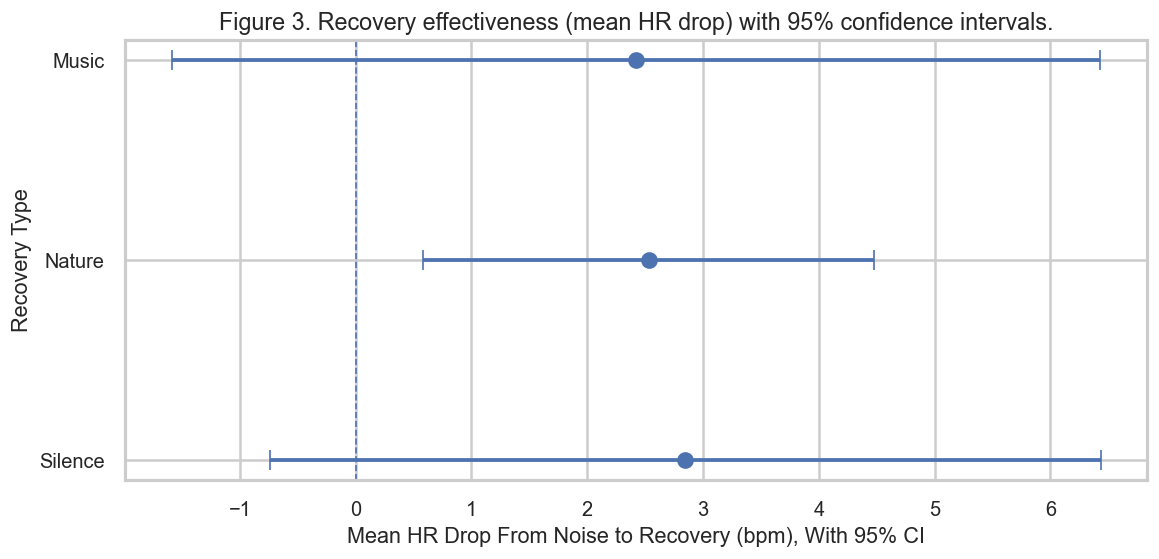

In [230]:
# =========================
# Figure: Primary outcome CIs
# =========================
plot_ci = hr_summary.copy()
plot_ci["xerr_low"] = plot_ci["Mean HR Drop (bpm)"] - plot_ci["95% CI (Low)"]
plot_ci["xerr_high"] = plot_ci["95% CI (High)"] - plot_ci["Mean HR Drop (bpm)"]

plt.figure(figsize=(10, 5))
y = np.arange(len(plot_ci))
plt.errorbar(
    plot_ci["Mean HR Drop (bpm)"], y,
    xerr=[plot_ci["xerr_low"], plot_ci["xerr_high"]],
    fmt="o", capsize=6
)
plt.yticks(y, plot_ci["Recovery Type"])
plt.axvline(0, linestyle="--", linewidth=1)
plt.xlabel("Mean HR Drop From Noise to Recovery (bpm), With 95% CI")
plt.ylabel("Recovery Type")
plt.title(next_figure("Recovery effectiveness (mean HR drop) with 95% confidence intervals."))
plt.tight_layout()

fig = plt.gcf()
#save_figure(fig, "Figure_3_MeanDrop_CIs")
plt.show()

In [231]:
# ---- Statistical models (methodology unchanged) ----
anova = AnovaRM(data=wide, depvar="delta_noise_to_recovery", subject="subject", within=["recovery_type"]).fit()
print(anova)

wide["recovery_type"] = pd.Categorical(wide["recovery_type"], categories=RECOVERY_ORDER, ordered=True)
m = smf.mixedlm("delta_noise_to_recovery ~ C(recovery_type)", data=wide, groups=wide["subject"]).fit(reml=True)
print(m.summary())

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
recovery_type  0.0185 2.0000 18.0000 0.9817

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: delta_noise_to_recovery
No. Observations: 30      Method:             REML                   
No. Groups:       10      Scale:              21.3071                
Min. group size:  3       Log-Likelihood:     -83.0622               
Max. group size:  3       Converged:          Yes                    
Mean group size:  3.0                                                
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   2.849    1.460  1.952 0.051 -0.012  5.710
C(recovery_type)[T.music]  -0.431    2.064 -0.209 0.835 -4.477  3.615
C(recovery_type)[T

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [232]:
# =========================
# Secondary outcome: Stability (volatility reduction)
# =========================
phase_vol = (df_long.groupby(["subject","recovery_type","phase"])["hr_bpm"]
             .agg(sd_hr="std", beats="count")
             .reset_index())

vol_wide = (phase_vol.pivot_table(index=["subject","recovery_type"], columns="phase", values="sd_hr")
            .reset_index())

vol_wide["sd_improve_noise_to_recovery"] = vol_wide["noise"] - vol_wide["recovery"]

display(vol_wide.head())

/var/folders/n5/z3_hbxx5557gt7c6h2ldp3140000gn/T/ipykernel_45728/3764457410.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  phase_vol = (df_long.groupby(["subject","recovery_type","phase"])["hr_bpm"]
/var/folders/n5/z3_hbxx5557gt7c6h2ldp3140000gn/T/ipykernel_45728/3764457410.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  vol_wide = (phase_vol.pivot_table(index=["subject","recovery_type"], columns="phase", values="sd_hr")


phase,subject,recovery_type,baseline,noise,recovery,sd_improve_noise_to_recovery
0,jacob,silence,7.622681,7.569065,4.512883,3.056182
1,jacob,music,5.755148,6.194299,5.288580,0.905719
2,jacob,nature,3.956012,12.006872,8.409761,3.597112
3,lucas,silence,14.284895,23.244853,4.121148,19.123705
4,lucas,music,2.637582,12.933483,24.364251,-11.430769


In [233]:
# =========================
# Table: Stability outcome (SD reduction) with 95% CI (no p-values shown)
# =========================
rows = []
for rt in RECOVERY_ORDER:
    x = vol_wide.loc[vol_wide["recovery_type"] == rt, "sd_improve_noise_to_recovery"].values
    n, m, lo, hi = mean_ci(x)
    rows.append({
        "Recovery Type": recovery_labels[rt],
        "Participants (n)": n,
        "Mean SD Reduction (bpm)": m,
        "95% CI (Low)": lo,
        "95% CI (High)": hi
    })

stab_summary = pd.DataFrame(rows).sort_values("Mean SD Reduction (bpm)", ascending=False).reset_index(drop=True)
stab_summary.insert(0, "Rank", np.arange(1, len(stab_summary) + 1))

print(next_table("Secondary outcome: reduction in heart-rate volatility (SD) from noise to recovery."))
display(stab_summary)
#save_table(stab_summary, "Table_4_Stability_SDReduction")

Table 5. Secondary outcome: reduction in heart-rate volatility (SD) from noise to recovery.


,Rank,Recovery Type,Participants (n),Mean SD Reduction (bpm),95% CI (Low),95% CI (High)
0,1,Nature,10,2.542785,0.710327,4.375243
1,2,Silence,10,1.975764,-2.626876,6.578404
2,3,Music,10,1.541033,-2.643225,5.725291


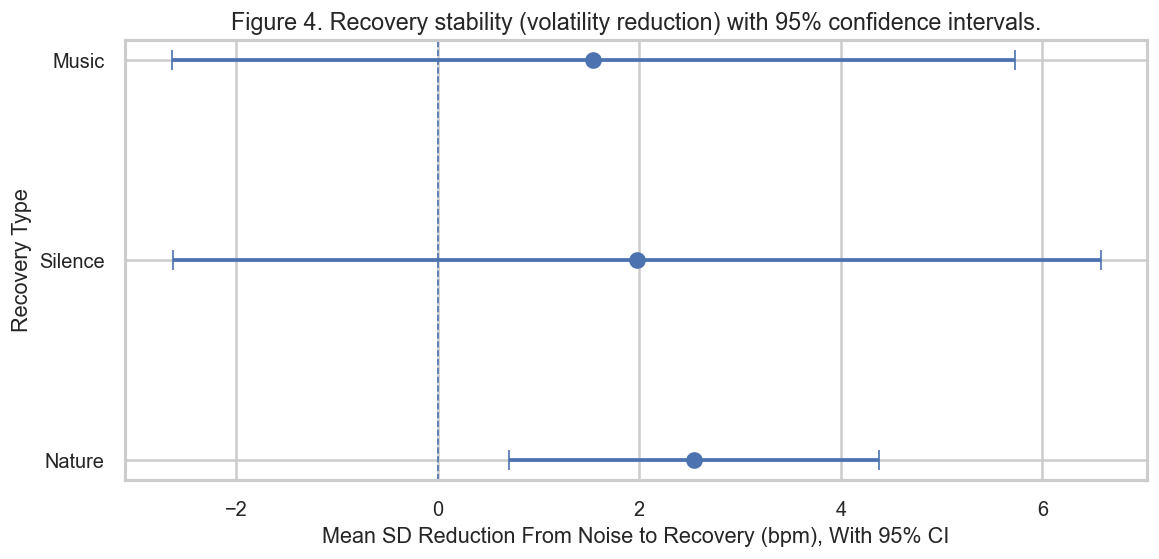

In [234]:
# =========================
# Figure: Stability outcome CIs
# =========================
plot_ci = stab_summary.copy()
plot_ci["xerr_low"] = plot_ci["Mean SD Reduction (bpm)"] - plot_ci["95% CI (Low)"]
plot_ci["xerr_high"] = plot_ci["95% CI (High)"] - plot_ci["Mean SD Reduction (bpm)"]

plt.figure(figsize=(10, 5))
y = np.arange(len(plot_ci))
plt.errorbar(
    plot_ci["Mean SD Reduction (bpm)"], y,
    xerr=[plot_ci["xerr_low"], plot_ci["xerr_high"]],
    fmt="o", capsize=6
)
plt.yticks(y, plot_ci["Recovery Type"])
plt.axvline(0, linestyle="--", linewidth=1)
plt.xlabel("Mean SD Reduction From Noise to Recovery (bpm), With 95% CI")
plt.ylabel("Recovery Type")
plt.title(next_figure("Recovery stability (volatility reduction) with 95% confidence intervals."))
plt.tight_layout()

fig = plt.gcf()
#save_figure(fig, "Figure_4_SDReduction_CIs")
plt.show()

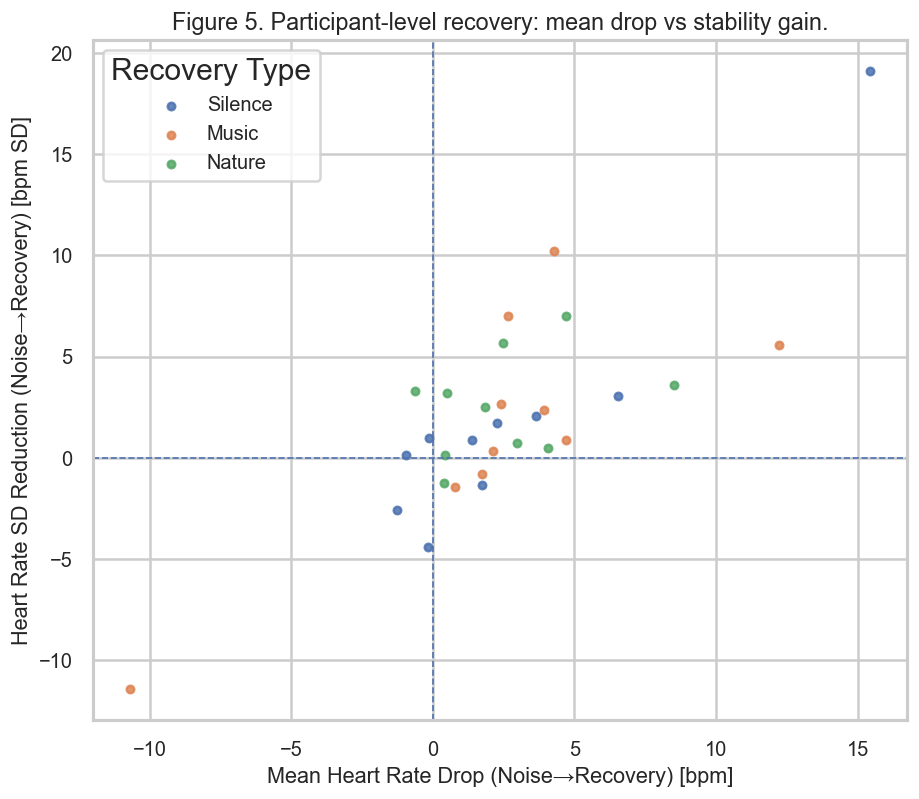

In [235]:
# =========================
# Figure: Mean HR drop vs SD reduction (participant-level)
# =========================
joint = wide[["subject", "recovery_type", "delta_noise_to_recovery"]].merge(
    vol_wide[["subject", "recovery_type", "sd_improve_noise_to_recovery"]],
    on=["subject", "recovery_type"],
    how="inner"
)

# Display labels (reuse existing label dicts if present)
phase_labels = {"baseline": "Baseline", "noise": "Noise", "recovery": "Recovery"}
recovery_labels = {"silence": "Silence", "music": "Music", "nature": "Nature"}

joint["Recovery Type"] = joint["recovery_type"].map(recovery_labels)
joint = joint.dropna(subset=["delta_noise_to_recovery", "sd_improve_noise_to_recovery", "Recovery Type"])

plt.figure(figsize=(8, 7))
for rt in ["Silence", "Music", "Nature"]:
    sub = joint[joint["Recovery Type"] == rt]
    plt.scatter(
        sub["delta_noise_to_recovery"],
        sub["sd_improve_noise_to_recovery"],
        label=rt,
        alpha=0.85,
        s=20
    )

plt.axvline(0, linestyle="--", linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Mean Heart Rate Drop (Noise→Recovery) [bpm]")
plt.ylabel("Heart Rate SD Reduction (Noise→Recovery) [bpm SD]")
plt.title(next_figure("Participant-level recovery: mean drop vs stability gain."))
plt.legend(title="Recovery Type", frameon=True)
plt.tight_layout()

fig = plt.gcf()
#save_figure(fig, "Figure_5_MeanDrop_vs_SDReduction")
plt.show()
